# Creating the Grid Polygon for the Analysis
source: https://james-brennan.github.io/posts/fast_gridding_geopandas/
The goal of this code is to create a grid across the entire bounds of the watershed. The dataset we are working with use 200 m long transects, so the size of each grid cell needs to be 200 m x 200 m.

In [1]:
#packages
import os
import geopandas as gpd
import shapely
from shapely.geometry import Polygon
import numpy as np
import rasterio as rio
from rasterio import plot
from rasterio.plot import show
from rasterio.plot import plotting_extent
from rasterio.mask import mask
import rioxarray as rxr
import xarray as xr
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import PIL
from PIL import Image

#check directory
cwd = os.getcwd()
cwd

'K:\\geog250\\PythonSWR'

In [2]:
#To figure out how many cells I need, I need to find out the number of pixels
#in the width/height of the area
im = Image.open("K:\geog250\PythonSWR/Landsat C2 L2 BF/MergedLandsatBands/band2_clipped.tif")
width, height = im.size
print(width,height)

#Each pixel is ~30 m, for a cell to be 200 m it needs to have 7 pixels

FileNotFoundError: [Errno 2] No such file or directory: '/Landsat C2 L2 BF/MergedLandsatBands/band2_clipped.tif'

In [3]:
#Open band 2 as xarray to get bounds
band2 = rxr.open_rasterio('K:\geog250\PythonSWR/Landsat C2 L2 BF/MergedLandsatBands/band2_clipped.tif') 

#Put band 2 in right crs
band2_repro= band2.rio.reproject('EPSG:3400')
band2_repro.rio.crs

CRS.from_epsg(3400)

In [4]:
#define bounds
xmin, ymin, xmax, ymax = band2_repro.rio.bounds()

#how many cells across and down
n_cells=207
cell_size = (xmax-xmin)/n_cells

#set crs
crs = "EPSG:3400"

# create the cells in a loop
grid_cells = []
for x0 in np.arange(xmin, xmax+cell_size, cell_size ):
    for y0 in np.arange(ymin, ymax+cell_size, cell_size):
        # bounds
        x1 = x0-cell_size
        y1 = y0+cell_size
        grid_cells.append( shapely.geometry.box(x0, y0, x1, y1)  )
cell = gpd.GeoDataFrame(grid_cells, columns=['geometry'], 
                                 crs=crs)
#grid = gpd.GeoDataFrame({'geometry':polygons})
cell.to_file("gridtest5.shp")

C:\Users\tribe\.conda\envs\geog250\lib\site-packages\geopandas\io\file.py:299: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,


In [10]:
#load wells
wells_pts = gpd.read_file("K:\geog250\PythonSWR/Shapefiles/PythonWells.shp")

#load newly created grid
grid = gpd.read_file('K:\geog250\PythonSWR/gridtest5.shp')

#Checking crs
print('gwells crs: ', wells_pts.crs)

gwells crs:  epsg:3400


<GeoAxesSubplot:>

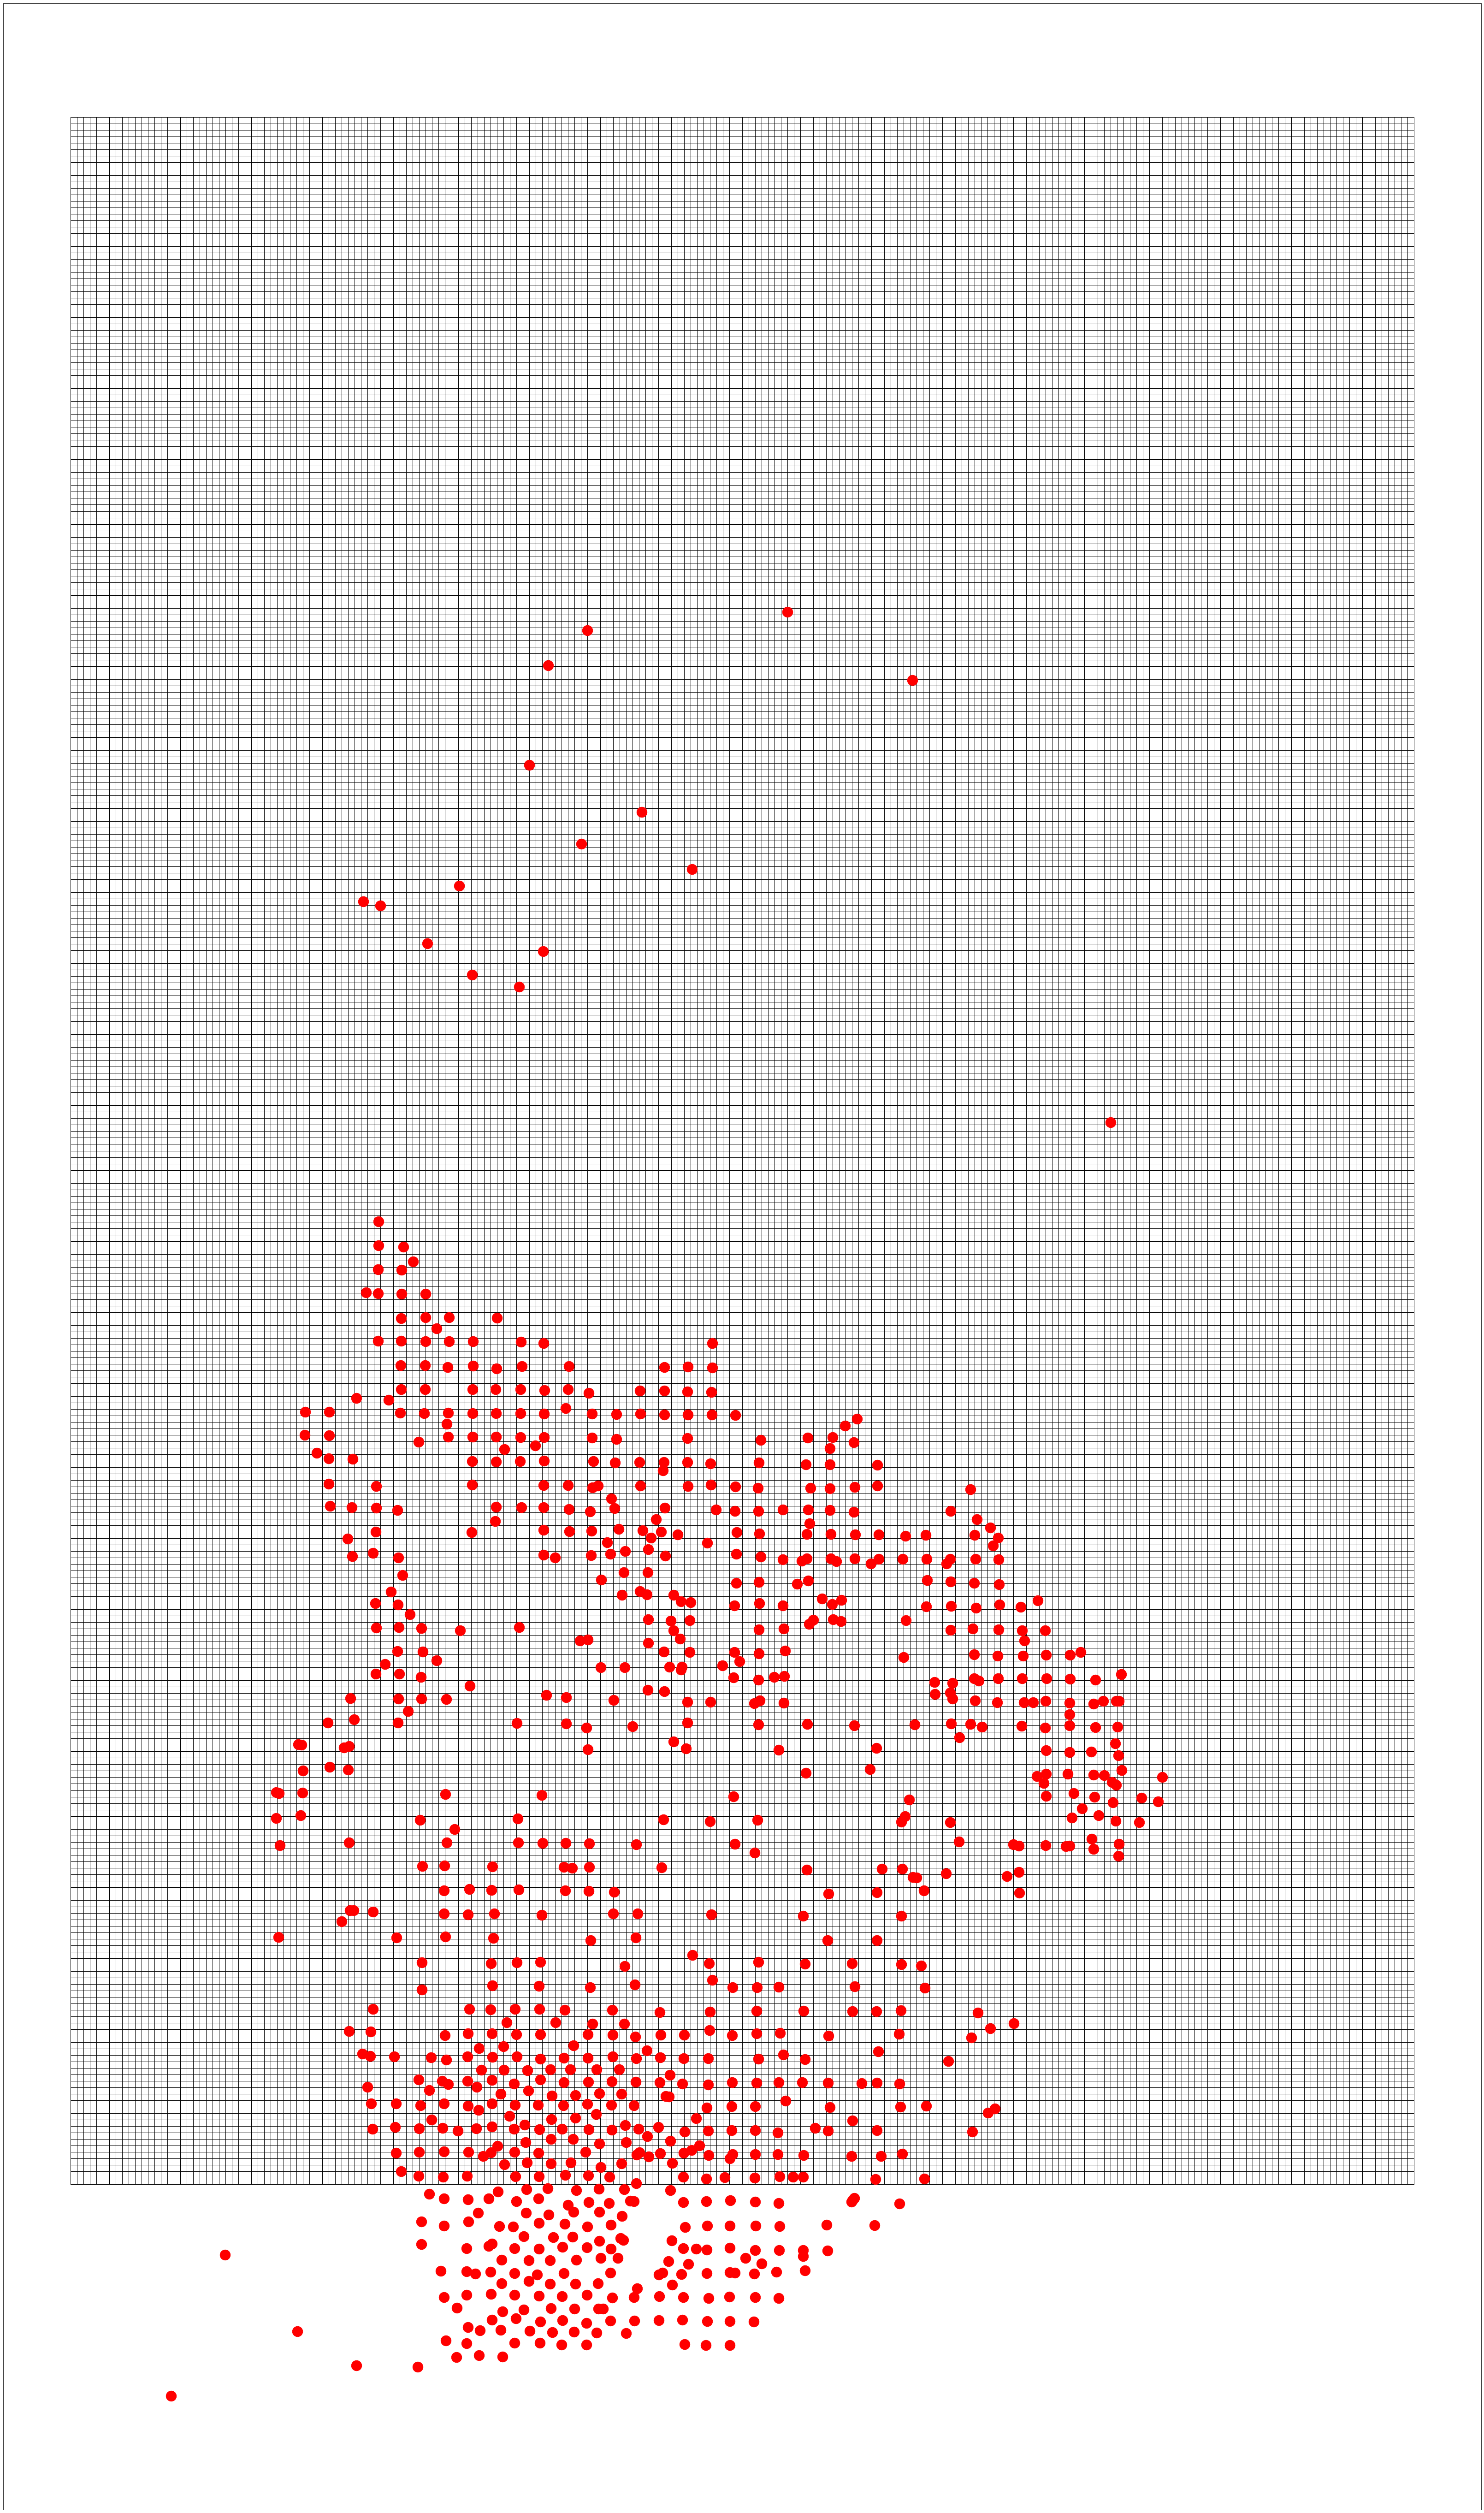

In [6]:
#Visualize the wells shapefile on top of the grid shapefile
plt.figure(figsize=(100,100))
ax = plt.axes(projection = ccrs.epsg(3400))
grid.plot(ax=ax, facecolor="none") #facecolor none very important
wells_pts.plot(ax=ax, color="red", edgecolor="red", markersize=500)
#The grid and wells don't line up perfectly here but they do at a later step so...